In [1]:
from scipy import signal
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

%matplotlib inline

In [27]:
# wavfile.py (Enhanced)
# Date: 20180430_2335 Joseph Basquin
#
# URL: https://gist.github.com/josephernest/3f22c5ed5dabf1815f16efa8fa53d476
# Source: scipy/io/wavfile.py
#
# Added:
# * read: also returns bitrate, cue markers + cue marker labels (sorted), loops, pitch
#         See https://web.archive.org/web/20141226210234/http://www.sonicspot.com/guide/wavefiles.html#labl
# * read: 24 bit & 32 bit IEEE files support (inspired from wavio_weckesser.py from Warren Weckesser)
# * read: added normalized (default False) that returns everything as float in [-1, 1]
# * read: added forcestereo that returns a 2-dimensional array even if input is mono
#
# * write: can write cue markers, cue marker labels, loops, pitch
# * write: 24 bit support
# * write: can write from a float normalized in [-1, 1] 
# * write: 20180430_2335: bug fixed when size of data chunk is odd (previously, metadata could become unreadable because of this)
#
# * removed RIFX support (big-endian) (never seen one in 10+ years of audio production/audio programming), only RIFF (little-endian) are supported
# * removed read(..., mmap)
#
#
# Test:
# ..\wav\____wavfile_demo.py


"""
Module to read / write wav files using numpy arrays
Functions
---------
`read`: Return the sample rate (in samples/sec) and data from a WAV file.
`write`: Write a numpy array as a WAV file.
"""
from __future__ import division, print_function, absolute_import

import numpy
import struct
import warnings
import collections
from operator import itemgetter

class WavFileWarning(UserWarning):
    pass
    
_ieee = False
    
# assumes file pointer is immediately
#  after the 'fmt ' id
def _read_fmt_chunk(fid):
    res = struct.unpack('<ihHIIHH',fid.read(20))
    size, comp, noc, rate, sbytes, ba, bits = res
    if (comp != 1 or size > 16):
        if (comp == 3):
            global _ieee
            _ieee = True
          #warnings.warn("IEEE format not supported", WavFileWarning)        
        else: 
            warnings.warn("Unfamiliar format bytes", WavFileWarning)
        if (size>16):
            fid.read(size-16)
    return size, comp, noc, rate, sbytes, ba, bits

# assumes file pointer is immediately
#   after the 'data' id
def _read_data_chunk(fid, noc, bits, normalized=False):
    size = struct.unpack('<i',fid.read(4))[0]

    if bits == 8 or bits == 24:
        dtype = 'u1'
        bytes = 1
    else:
        bytes = bits//8
        dtype = '<i%d' % bytes
        
    if bits == 32 and _ieee:
        dtype = 'float32'
        
    data = numpy.fromfile(fid, dtype=dtype, count=size//bytes)
    
    if bits == 24:
        a = numpy.empty((len(data) // 3, 4), dtype='u1')
        a[:, :3] = data.reshape((-1, 3))
        a[:, 3:] = (a[:, 3 - 1:3] >> 7) * 255
        data = a.view('<i4').reshape(a.shape[:-1])
    
    if noc > 1:
        data = data.reshape(-1,noc)
        
    if bool(size & 1):     # if odd number of bytes, move 1 byte further (data chunk is word-aligned)
        fid.seek(1,1)    

    if normalized:
        if bits == 8 or bits == 16 or bits == 24: 
            normfactor = 2 ** (bits-1)
        data = numpy.float32(data) * 1.0 / normfactor

    return data

def _skip_unknown_chunk(fid):
    data = fid.read(4)
    size = struct.unpack('<i', data)[0]
    if bool(size & 1):     # if odd number of bytes, move 1 byte further (data chunk is word-aligned)
        size += 1 
    fid.seek(size, 1)

def _read_riff_chunk(fid):
    str1 = fid.read(4)
    if str1 != b'RIFF':
        raise ValueError("Not a WAV file.")
    fsize = struct.unpack('<I', fid.read(4))[0] + 8
    str2 = fid.read(4)
    if (str2 != b'WAVE'):
        raise ValueError("Not a WAV file.")
    return fsize


def read(file, readmarkers=False, readmarkerlabels=False, readmarkerslist=False, readloops=False, readpitch=False, normalized=False, forcestereo=False):
    """
    Return the sample rate (in samples/sec) and data from a WAV file
    Parameters
    ----------
    file : file
        Input wav file.
    Returns
    -------
    rate : int
        Sample rate of wav file
    data : numpy array
        Data read from wav file
    Notes
    -----
    * The file can be an open file or a filename.
    * The returned sample rate is a Python integer
    * The data is returned as a numpy array with a
      data-type determined from the file.
    """
    if hasattr(file,'read'):
        fid = file
    else:
        fid = open(file, 'rb')

    fsize = _read_riff_chunk(fid)
    noc = 1
    bits = 8
    #_cue = []
    #_cuelabels = []
    _markersdict = collections.defaultdict(lambda: {'position': -1, 'label': ''})
    loops = []
    pitch = 0.0
    while (fid.tell() < fsize):
        # read the next chunk
        chunk_id = fid.read(4)
        if chunk_id == b'fmt ':
            size, comp, noc, rate, sbytes, ba, bits = _read_fmt_chunk(fid)
        elif chunk_id == b'data':
            data = _read_data_chunk(fid, noc, bits, normalized)
        elif chunk_id == b'cue ':
            str1 = fid.read(8)
            size, numcue = struct.unpack('<ii',str1)
            for c in range(numcue):
                str1 = fid.read(24)
                id, position, datachunkid, chunkstart, blockstart, sampleoffset = struct.unpack('<iiiiii', str1)
                #_cue.append(position)
                _markersdict[id]['position'] = position                    # needed to match labels and markers

        elif chunk_id == b'LIST':
            str1 = fid.read(8)
            size, type = struct.unpack('<ii', str1)
        elif chunk_id in [b'ICRD', b'IENG', b'ISFT', b'ISTJ']:    # see http://www.pjb.com.au/midi/sfspec21.html#i5
            _skip_unknown_chunk(fid)
        elif chunk_id == b'labl':
            str1 = fid.read(8)
            size, id = struct.unpack('<ii',str1)
            size = size + (size % 2)                              # the size should be even, see WAV specfication, e.g. 16=>16, 23=>24
            label = fid.read(size-4).rstrip('\x00')               # remove the trailing null characters
            #_cuelabels.append(label)
            _markersdict[id]['label'] = label                           # needed to match labels and markers

        elif chunk_id == b'smpl':
            str1 = fid.read(40)
            size, manuf, prod, sampleperiod, midiunitynote, midipitchfraction, smptefmt, smpteoffs, numsampleloops, samplerdata = struct.unpack('<iiiiiIiiii', str1)
            cents = midipitchfraction * 1./(2**32-1)
            pitch = 440. * 2 ** ((midiunitynote + cents - 69.)/12)
            for i in range(numsampleloops):
                str1 = fid.read(24)
                cuepointid, type, start, end, fraction, playcount = struct.unpack('<iiiiii', str1) 
                loops.append([start, end])
        else:
#             warnings.warn("Chunk " + chunk_id + " skipped", WavFileWarning)
            _skip_unknown_chunk(fid)
    fid.close()

    if data.ndim == 1 and forcestereo:
        data = numpy.column_stack((data, data))

    _markerslist = sorted([_markersdict[l] for l in _markersdict], key=lambda k: k['position'])  # sort by position
    _cue = [m['position'] for m in _markerslist]
    _cuelabels = [m['label'] for m in _markerslist]
    
    return (rate, data, bits, ) \
        + ((_cue,) if readmarkers else ()) \
        + ((_cuelabels,) if readmarkerlabels else ()) \
        + ((_markerslist,) if readmarkerslist else ()) \
        + ((loops,) if readloops else ()) \
        + ((pitch,) if readpitch else ())


def write(filename, rate, data, bitrate=None, markers=None, loops=None, pitch=None, normalized=False):
    """
    Write a numpy array as a WAV file
    Parameters
    ----------
    filename : file
        The name of the file to write (will be over-written).
    rate : int
        The sample rate (in samples/sec).
    data : ndarray
        A 1-D or 2-D numpy array of integer data-type.
    Notes
    -----
    * Writes a simple uncompressed WAV file.
    * The bits-per-sample will be determined by the data-type.
    * To write multiple-channels, use a 2-D array of shape
      (Nsamples, Nchannels).
    """

    # normalization and 24-bit handling
    if bitrate == 24:   # special handling of 24 bit wav, because there is no numpy.int24...
        if normalized:
            data[data > 1.0] = 1.0
            data[data < -1.0] = -1.0
            a32 = numpy.asarray(data * (2 ** 23 - 1), dtype=numpy.int32)
        else:
            a32 = numpy.asarray(data, dtype=numpy.int32)
        if a32.ndim == 1:               
            a32.shape = a32.shape + (1,)  # Convert to a 2D array with a single column.
        a8 = (a32.reshape(a32.shape + (1,)) >> numpy.array([0, 8, 16])) & 255  # By shifting first 0 bits, then 8, then 16, the resulting output is 24 bit little-endian.
        data = a8.astype(numpy.uint8)
    else:
        if normalized:   # default to 32 bit int
            data[data > 1.0] = 1.0
            data[data < -1.0] = -1.0
            data = numpy.asarray(data * (2 ** 31 - 1), dtype=numpy.int32)

    fid = open(filename, 'wb')
    fid.write(b'RIFF')
    fid.write(b'\x00\x00\x00\x00')
    fid.write(b'WAVE')

    # fmt chunk
    fid.write(b'fmt ')
    if data.ndim == 1:
        noc = 1
    else:
        noc = data.shape[1]
    bits = data.dtype.itemsize * 8 if bitrate != 24 else 24
    sbytes = rate * (bits // 8) * noc
    ba = noc * (bits // 8)
    fid.write(struct.pack('<ihHIIHH', 16, 1, noc, rate, sbytes, ba, bits))

    # cue chunk
    if markers:    # != None and != []
        if isinstance(markers[0], dict):       # then we have [{'position': 100, 'label': 'marker1'}, ...]
            labels = [m['label'] for m in markers]
            markers = [m['position'] for m in markers]
        else:
            labels = ['' for m in markers]

        fid.write(b'cue ')
        size = 4 + len(markers) * 24
        fid.write(struct.pack('<ii', size, len(markers)))
        for i, c in enumerate(markers):
            s = struct.pack('<iiiiii', i + 1, c, 1635017060, 0, 0, c)           # 1635017060 is struct.unpack('<i',b'data')
            fid.write(s)

        lbls = ''
        for i, lbl in enumerate(labels):
            lbls += b'labl'
            label = lbl + ('\x00' if len(lbl) % 2 == 1 else '\x00\x00')
            size = len(lbl) + 1 + 4          # because \x00
            lbls += struct.pack('<ii', size, i + 1)
            lbls += label

        fid.write(b'LIST')
        size = len(lbls) + 4 
        fid.write(struct.pack('<i', size))                         
        fid.write(b'adtl')                                                      # https://web.archive.org/web/20141226210234/http://www.sonicspot.com/guide/wavefiles.html#list
        fid.write(lbls)        

    # smpl chunk
    if loops or pitch:
        if not loops:
            loops = []
        if pitch:
            midiunitynote = 12 * numpy.log2(pitch * 1.0 / 440.0) + 69
            midipitchfraction = int((midiunitynote - int(midiunitynote)) * (2**32-1))
            midiunitynote = int(midiunitynote)
            #print(midipitchfraction, midiunitynote)
        else:
            midiunitynote = 0
            midipitchfraction = 0
        fid.write(b'smpl')
        size = 36 + len(loops) * 24
        sampleperiod = int(1000000000.0 / rate)

        fid.write(struct.pack('<iiiiiIiiii', size, 0, 0, sampleperiod, midiunitynote, midipitchfraction, 0, 0, len(loops), 0))
        for i, loop in enumerate(loops):
            fid.write(struct.pack('<iiiiii', 0, 0, loop[0], loop[1], 0, 0))

    # data chunks
    fid.write(b'data')
    fid.write(struct.pack('<i', data.nbytes))
    import sys
    if data.dtype.byteorder == '>' or (data.dtype.byteorder == '=' and sys.byteorder == 'big'):
        data = data.byteswap()

    data.tofile(fid)

    if data.nbytes % 2 == 1: # add an extra padding byte if data.nbytes is odd: https://web.archive.org/web/20141226210234/http://www.sonicspot.com/guide/wavefiles.html#data
        fid.write('\x00')

    # Determine file size and place it in correct
    #  position at start of the file.
    size = fid.tell()
    fid.seek(4)
    fid.write(struct.pack('<i', size-8))
    fid.close()

In [3]:
def fftSpect(x, fs):

    N = len(x)

    # fft of a real array. Negative frequencies are discarded.
    X = np.fft.rfft(x)

    # f_nyq=floor(N/2)
    f_nyq = N // 2
    f = fs / N * np.arange(0, f_nyq + 1)

    P = abs(X / N)

    return f, P

In [4]:
# Setup the plots directory
plotsDir = "./plots/"
if not os.path.isdir(plotsDir):
    os.mkdir(plotsDir)
print('Output Directory:', plotsDir)   

Output Directory: ./plots/




File:  test1_int16.wav
Signal Length:  1454774
Sample Rate:  44100 Hz
Data Type:  int16


File:  test2_int16.wav
Signal Length:  359933
Sample Rate:  32000 Hz
Data Type:  int16


File:  test3_int24.wav
Signal Length:  359933
Sample Rate:  32000 Hz
Data Type:  int32


File:  test4_float32.wav
Signal Length:  359933
Sample Rate:  32000 Hz
Data Type:  float32


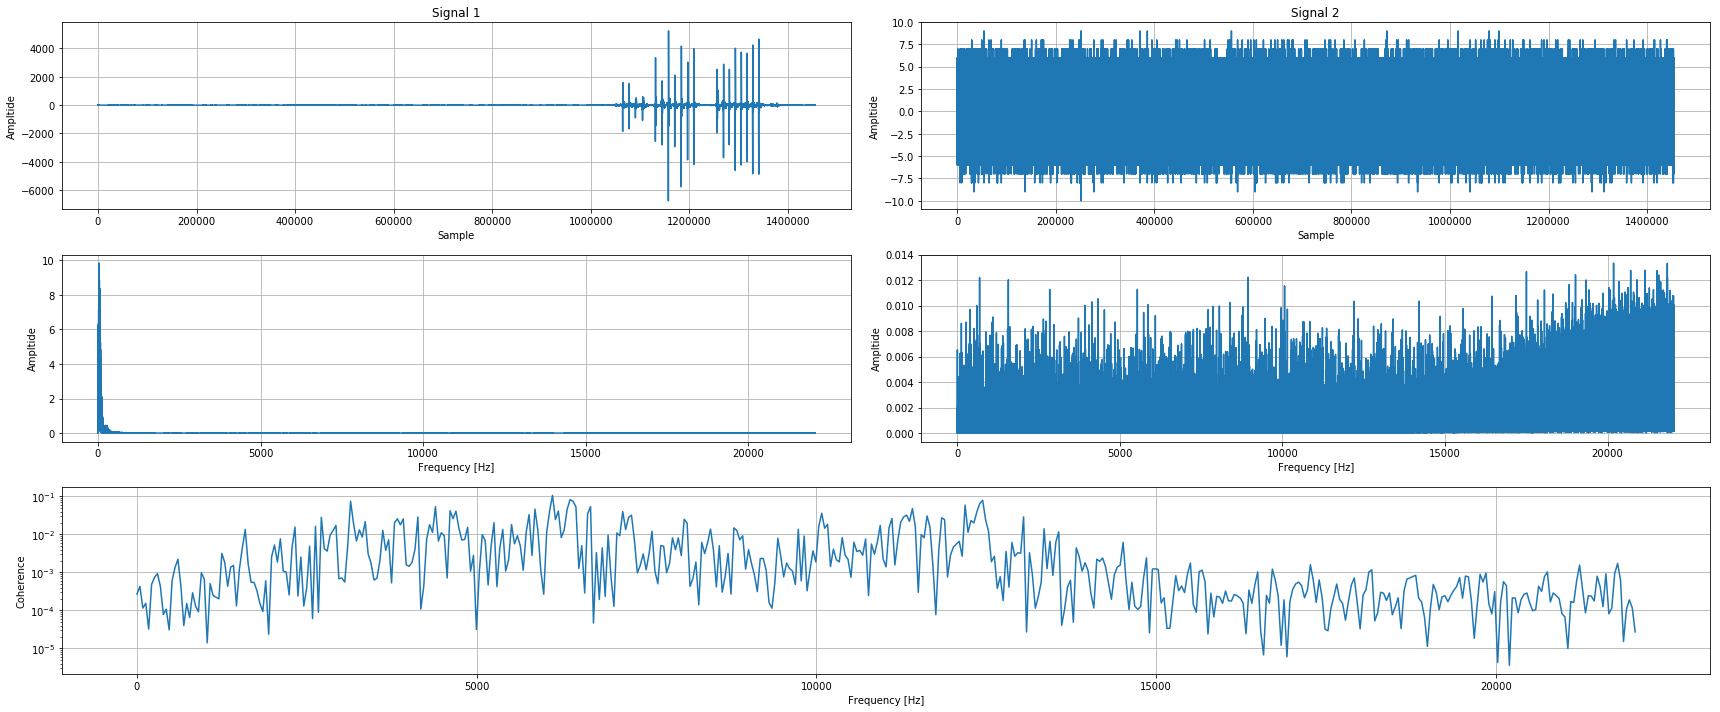

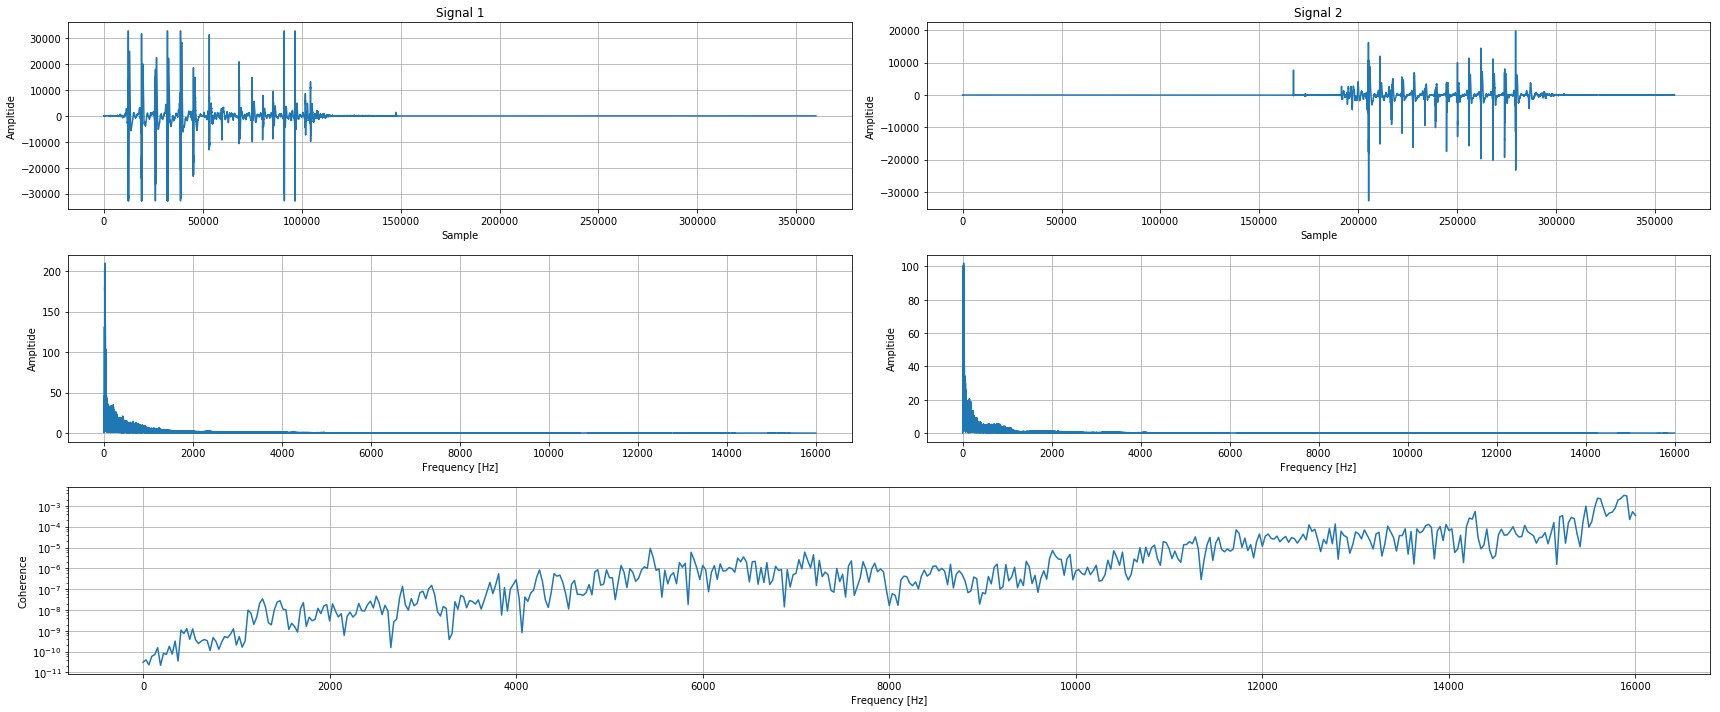

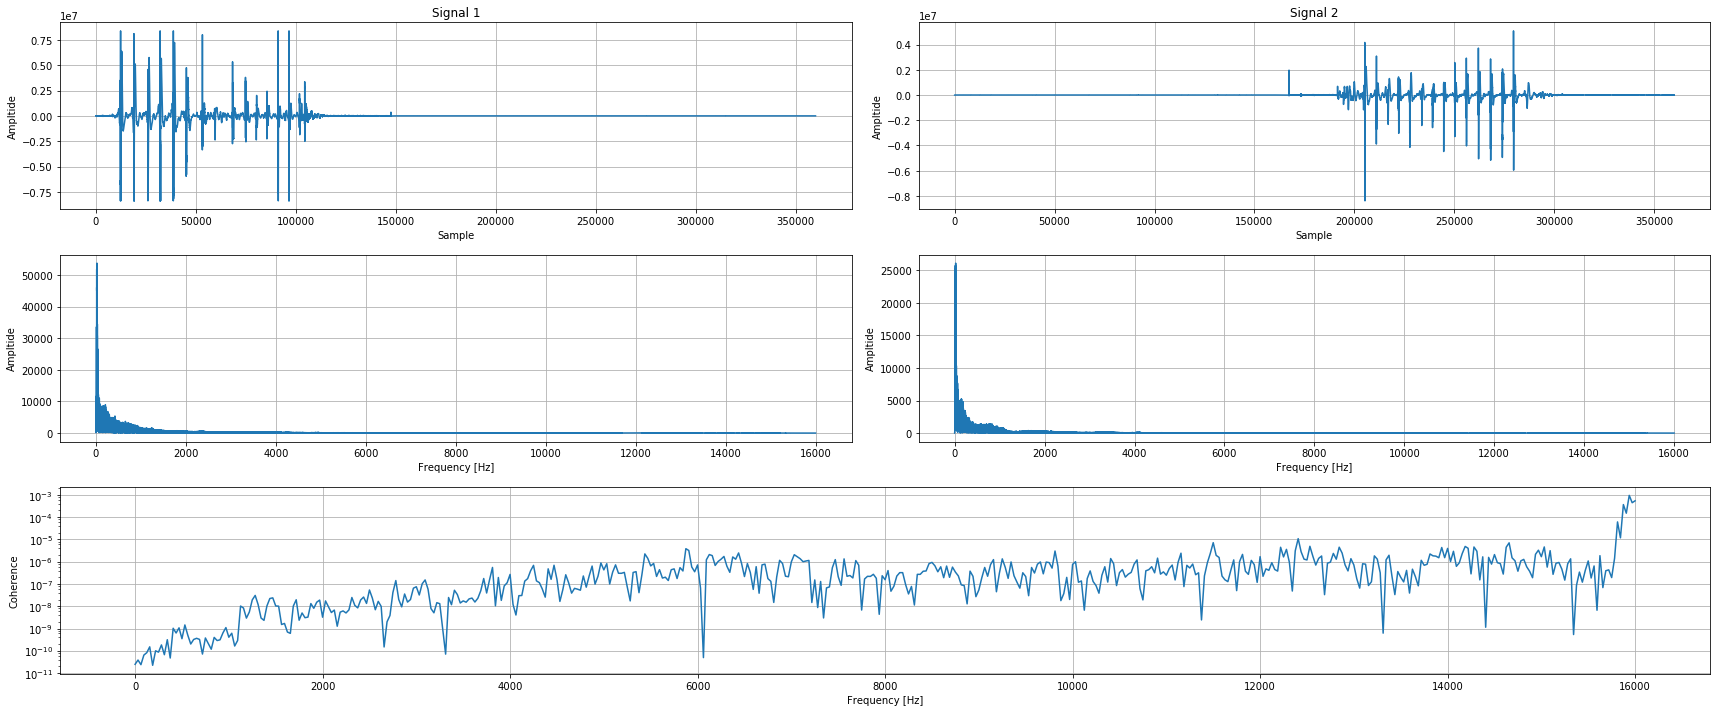

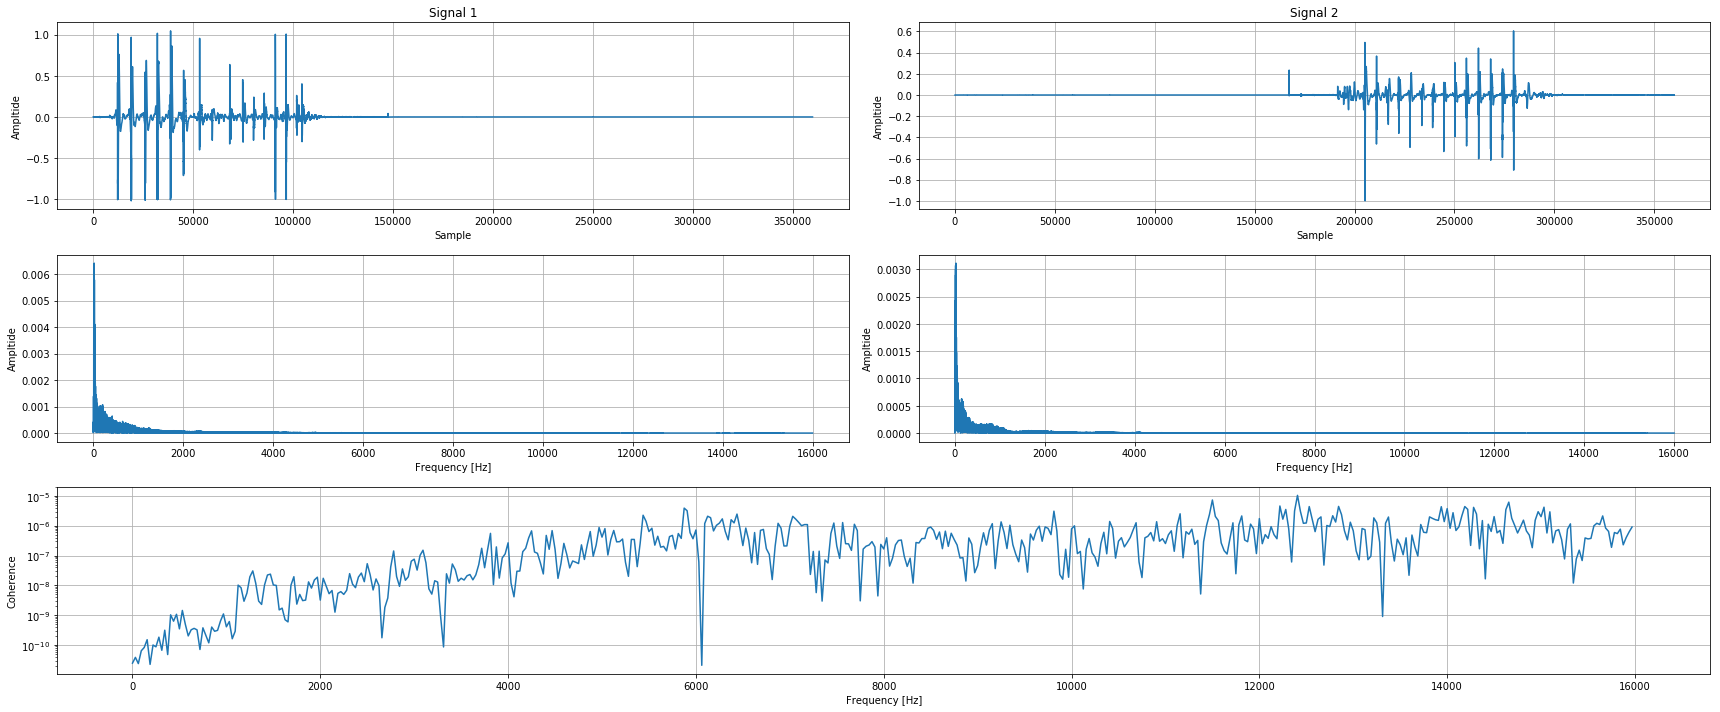

In [28]:
wavefiles = glob.glob('*.wav')
for file in wavefiles:
    try:
        (fs, x, b) = read(os.path.join('./', file))

        x1 = x[:,0]
        x2 = x[:,1]

        print('\n')
        print('File: ', file)
        print('Signal Length: ', len(x1))
        print('Sample Rate: ', fs, 'Hz')
        print('Data Type: ', x.dtype)

        # compute frequency spectrum
        [f1, P1] = fftSpect(x1, fs)
        [f2, P2] = fftSpect(x2, fs)

        # compute coherence between signals
        f, Cxy = signal.coherence(x1, x2, fs, nperseg=1024)

        # plot signals
        fig = plt.figure(figsize=[24,10])

        gs = GridSpec(3, 2)
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(x1)
        ax1.set_xlabel('Sample')
        ax1.set_ylabel('Ampltide')
        ax1.set_title('Signal 1')
        ax1.grid()

        ax2 = fig.add_subplot(gs[0, 1])
        ax2.plot(x2)
        ax2.set_xlabel('Sample')
        ax2.set_ylabel('Ampltide')
        ax2.set_title('Signal 2')
        ax2.grid()

        ax3 = fig.add_subplot(gs[1, 0])
        ax3.plot(f1, P1)
        ax3.set_xlabel('Frequency [Hz]')
        ax3.set_ylabel('Ampltide')
        ax3.grid()

        ax4 = fig.add_subplot(gs[1, 1])
        ax4.plot(f2, P2)
        ax4.set_xlabel('Frequency [Hz]')
        ax4.set_ylabel('Ampltide')
        ax4.grid()

        ax5 = fig.add_subplot(gs[2, :])
        ax5.semilogy(f, Cxy)
        ax5.set_xlabel('Frequency [Hz]')
        ax5.set_ylabel('Coherence')
        ax5.grid()

        plt.tight_layout()

        fig.savefig(os.path.join(plotsDir, file) + '.png')
    except:  
        print('Error: cannot read the wave file. The format is unkown.')